# Query-by-humming model tutorial


In [148]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import IPython.display as ipd
from pydub import AudioSegment
import matplotlib.pyplot as plt
import random
import monitoring

from sampling_utils import downsample_contour_array
%load_ext autoreload
%autoreload 2

import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Metadata of DB

Meta data is saved as a list of dictionary.
Each item in the list represents a single track.


- db_metadata: database consists of music100k + music120k
- humm_test_meta: database consists of 100 pieces selected by FLO

Caution: 'track_id' is the one corresponds to actual file name, not a 'song_id'.
Since the provided metadata for each dataset is different, dictionary key for each metadata set is different from each other.


Belows are the list of genre name and the corresponding id. + sign represents that the genre was included during the QbH model training

- 해외 메탈 18
- 국내 발라드 4 +
- 해외 힙합 14
- 기타 30
- 클래식 20
- 재즈 22
- 국내 락/메탈 12 + 
- 해외 팝 13 + 
- 월드뮤직 26
- 해외 락 17 + 
- J-POP 25
- 뉴에이지 21
- 국내 알앤비 7 + 
- CCM 28
- 해외 알앤비 15 + 
- 맘/태교 24
- OST/BGM 19
- 국내 댄스/일렉 5
- 해외 일렉트로닉 16
- 트로트 8
- 국내 포크/블루스 11 + 
- 키즈 23
- 국내 인디 9 +
- 종교음악 29
- 국악 27
- 국내 팝/어쿠스틱 10 +
- 국내 힙합 6

In [43]:
with open("flo_metadata_220k.dat", 'rb') as f:
    db_metadata = pickle.load(f)

humm_test_meta = pd.read_csv('flo_test_list.csv').to_dict('records')

# print first track as an example
print("1. db_metadata example:", db_metadata[0])
print("2. flo_test_metadata example:", humm_test_meta[0])

1. db_metadata example: {'song_id': 427675419, 'artist_id_basket': [80141499], 'artist_name_basket': ['AKMU (악동뮤지션)'], 'album_id': 403299537, 'album_name': '항해', 'track_id': 427675419, 'track_name': '어떻게 이별까지 사랑하겠어, 널 사랑하는 거지', 'label_name_basket': ['YG Entertainment'], 'genre_id_basket': [4], 'genre_name_basket': ['국내 발라드'], 'publish_date': 20190925, 'play_count': 13161405}
2. flo_test_metadata example: {'곡명': 'You Give Me Something', '아티스트명': 'James Morrison', '해당 요건': 'CF', '비고': 'KTX 광고', 'url': 'https://www.music-flo.com/detail/track/hdnzyzeh/details', 'track id': 80269648}


## 1. Melody data from audio file

"Melody" of music is extracted using singing voice estimation model.
The result is saved in txt format.

This section demonstrates how the result is formatted

In [44]:
# define dataset path
dataset_dir = Path('/home/svcapp/t2meta/flo_new_music/music_100k/')
# define target genre
selected_genres = [4]

In [45]:
from melody_utils import MelodyLoader
from data_utils import get_song_ids_of_selected_genre, song_id_to_pitch_txt_path

### Get a list of song id and corresponding pitch path

In [46]:
song_ids = get_song_ids_of_selected_genre(db_metadata, selected_genres)
melody_loader = MelodyLoader(dataset_dir)
melody_loader.check_txt_exists(song_ids, make_txt=False) # Set make_txt=True to make txt


Check passed: Every song has corresponding txt


#### The following shows the example of windowed melody.

- melody_of_piece: list of dict
    - 'contour': numpy array of contour
    - 'song_id': 'track_id' of the song
    - 'frame_pos': slice position in 10ms

In [47]:
# can select any index < len(song_ids)
index = 0 
target_song_id = song_ids[index]
melodies_of_piece = melody_loader(target_song_id)
print(melodies_of_piece[0])

{'contour': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'song_id': 427675419, 'frame_pos': (13000, 15000)}


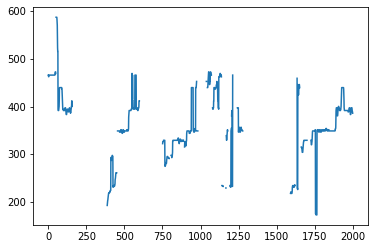

In [48]:
# Monitor data with plot and audio
melody_idx = random.randint(0, len(melodies_of_piece)-1)
selected_melody = melodies_of_piece[melody_idx]

# The contour was converted into log scale and then normalized with mean/std
# Therefore, this process 
contour_in_hz_scale = np.copy(selected_melody['contour']) 
contour_in_hz_scale[:,0] = monitoring.normalized_vec_to_orig(selected_melody['contour'])
monitoring.plot_contour_with_voice_only(contour_in_hz_scale)

orig_audio, contour_audio = monitoring.get_audio_and_sine_from_contour_data(selected_melody, dataset_dir)
ipd.display(ipd.Audio(orig_audio, rate=44100))
ipd.display(ipd.Audio(contour_audio, rate=44100))
ipd.display(ipd.Audio((orig_audio+contour_audio)/2, rate=44100))


## 2. Humming data from HummingDB
- HummingDB consists of humming audio and metadata
- "Spec.xlsx" includes metadata of humming audio
- 900 songs were selected from flo_metadata.dat (original music_100k dataset)
- 100 songs were selected by FLO
- Since we don't have detailed metadata for 100 songs selected by FLO, meta format is slightly different.

In [49]:
humming_data_dir = Path('/home/svcapp/userdata/humming_db')

In [50]:
import humming_data_utils as humming

selected_100, selected_900 = humming.load_meta_from_excel(xlsx_path=humming_data_dir/"Spec.xlsx", meta_path="flo_metadata_220k.dat", meta_100_path='meta_100.dat')
humming_db = humming.HummingDB(humming_data_dir, dataset_dir, selected_100, selected_900)


In [51]:
# Print example
humming_db[0]

{'humm': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'orig': array([[-1.19150787,  1.        ],
        [-1.19150787,  1.        ],
        [-1.19150787,  1.        ],
        ...,
        [ 0.66531312,  1.        ],
        [ 0.66531312,  1.        ],
        [ 0.66531312,  1.        ]]),
 'meta': {'path': '/home/svcapp/userdata/humming_db/100/0~24/01_P/100_0_A_105-125_(PF_KRJ).wav',
  'pitch_path': '/home/svcapp/userdata/humming_db/100/0~24/01_P/100_0_A_105-125_(PF_KRJ).f0.csv',
  'song_group': '100',
  'song_idx': '0',
  'humming_type': 'A',
  'time_stamp': '105-125',
  'singer_group': 'P',
  'singer_id': 'KRJ',
  'singer_gender': 'F',
  'track_id': 80269648}}

- 'humm': array of humming melody. Time resolution is 10 ms
- 'orig': array of original melody, extracted from original recording by automatic singing voice estimator. Time resolution is 10 ms. The slice position was selected based on 'meta'-'time_stamp'
- 'meta': metadata of humming sample.
    - 'path': path to humming audio
    - 'pitch_path': path to f0 curve extracted from humming audio by crepe algorithm.
    - 'song_group': '100' or '900',
    - 'song_idx': song idx in humming list
    - 'humming_type': 'A' for mouth-closed humming, 'B' for humming with A vowel, 'C' for singing with lyric, 'D' for freely selected by singer
    - 'time_stamp': str(A-B) that represents time stamp of humming in original audio, in seconds. Notated by the singer.
    - 'singer_group': 'P' for professional, 'N' for non-professional
    - 'singer_id': initial of singer name
    - 'singer_gender': 'M' or 'F'
    - 'track_id': track_id of the corresponding original song
    


## 3. QbH Model

QbH model takes melody input and embed it into a 512-dim vector.

- Input is a tensor of B x N x 2.
- B is number of batch.
- N is number of frames in 100 ms. (The original txt or csv file has melody in 10 ms. Therefore, the melody has to be downsampled before feeding it into QbH model)
- Output is a tensor of B x 512

In [52]:
from test_qbh import load_model
import torch
model_dir = Path('/home/svcapp/t2meta/qbh_model')
model_id = 485391
ckpt_dir = next(model_dir.glob(f"worker_{model_id}*"))
device = 'cuda'

encoder_model, hparams = load_model(ckpt_dir, device=device)

Loading checkpoint '/home/svcapp/t2meta/qbh_model/worker_485391_contour_scheduled_hidden256_lr0.0001_210411-053630/checkpoint_best.pt'
Loading checkpoint '/home/svcapp/t2meta/qbh_model/worker_485391_contour_scheduled_hidden256_lr0.0001_210411-053630/checkpoint_best.pt'
Loaded checkpoint '/home/svcapp/t2meta/qbh_model/worker_485391_contour_scheduled_hidden256_lr0.0001_210411-053630/checkpoint_best.pt' from iteration 300001


In [53]:
# contour has to be downsampled from 10ms resolution to 100ms resolution (10-to-1 downsample)
contour = downsample_contour_array(selected_melody['contour'])

# change contour as a tensor of Batch X Length X 2
contour_tensor = torch.Tensor(contour).unsqueeze(0).to(device)

# get_embedding:
contour_embedding = encoder_model(contour_tensor)
print(contour_embedding.shape, contour_embedding)

torch.Size([1, 512]) tensor([[-3.2923e-02,  2.4548e-02, -2.8300e-02,  6.8227e-02, -1.3288e-01,
         -1.9502e-03,  1.2561e-02, -1.2722e-02, -1.4488e-01,  7.2297e-02,
         -1.0935e-01, -6.0021e-03,  4.0445e-02, -7.1522e-03,  3.9251e-03,
          4.0623e-02,  5.4116e-02, -3.0541e-03, -5.8245e-02, -2.0073e-02,
         -5.5651e-02, -2.4731e-02,  7.5884e-02, -1.6631e-02, -3.5037e-03,
         -1.6819e-01, -5.4273e-02, -1.4539e-02, -4.4678e-02, -5.5420e-02,
         -8.5832e-02, -9.6687e-03,  2.6131e-03,  1.2902e-02,  9.6935e-02,
          4.0336e-02,  7.3795e-02,  2.5065e-02,  8.6391e-02,  4.2665e-02,
          7.8457e-02, -5.5780e-02, -5.6034e-02,  2.1225e-02,  6.4567e-02,
         -1.5539e-03, -2.8953e-02,  1.7372e-02, -3.5390e-02,  3.1671e-02,
         -4.8719e-02, -2.2193e-02,  8.9315e-03, -3.5808e-02,  9.0510e-02,
         -4.6062e-02, -6.9074e-02,  9.6115e-03,  1.2586e-02,  1.4237e-01,
         -6.6212e-02, -6.9084e-02,  3.5367e-02, -2.1464e-02,  5.7053e-02,
         -6.9926e

## 4 Training
### 4-1 Training Dataset and Data Augmentation


- humming_db_contour_pairs.dat was generated by humming_data_utils.py

In [54]:
from train import prepare_dataloaders, prepare_entire_loader, prepare_humming_db_loaders
from hparams import HParams

# Pre-defined hparams can be loaded from load_model.
# Otherwise, you can define new one with following 
# hparams = HParams()
hparams.meta_path = 'flo_metadata_220k.dat'
hparams.humming_path = '/home/svcapp/userdata/flo_melody/humming_db_contour_pairs.dat'
hparams.data_dir = dataset_dir
hparams.batch_size = 64
hparams.valid_batch_size = 128
hparams.end_to_end = False

# Load entire_loader, which includes every song in the database for selected genre
# num_song_limit is just for testing with small dataset
# add_humm=True add songs that are included in HummingDB to the entire_loader. If not, we cannot search song with a humming query because the song is not included in the dataset
entire_loader = prepare_entire_loader(hparams, num_song_limit=1000, add_humm=True)
train_loader, val_loader = prepare_dataloaders(hparams, entire_loader)
humm_train_loader, humm_val_loader = prepare_humming_db_loaders(hparams)

- train_loader: 
    - load tensor from MelodyDB. 
    - Anchor is a melody from a song in MelodyDB
    - Positive samples are generated by melody augmentation of anchor melody.
    - Negative samples are from other piece of music (with different track_id)
- humm_train_loader: 
    - load tensor from HummingDB. 
    - Anchor is a f0 contour from a humming in HummingDB
    - Positive samples are original melody of the same song and its augmentation from Melody DB
    - Negative samples are from other piece of music (with different track_id)

In [55]:
train_loader_sample = next(iter(train_loader))
humm_loader_sample = next(iter(humm_train_loader))

print(train_loader_sample.shape) # (Num_Batch X (1 + num_pos + num_neg)) X max_length X 2
print(humm_loader_sample.shape) # (Num_Batch X (1 + num_pos + num_neg)) X max_length X 2

torch.Size([1088, 315, 2])
torch.Size([1088, 654, 2])


### Monitoring data augmentation
- Anchor sample is an automatically-extracted melody 
- Positive samples are augmented version of anchor sample
    - pitch shift
    - tempo change
    - voice fill in
    - pitch noise
    - tempo noise
    - masking
- Negative samples are melody from songs with different track_id

#### The plot below shows example of Anchor, Positive sample, Negative sample

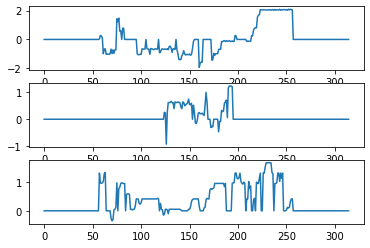

In [56]:
example_id = 0
example_of_single_pair = train_loader_sample.view(-1, 1+train_loader.dataset.num_aug_samples+train_loader.dataset.num_neg_samples, train_loader_sample.shape[1], train_loader_sample.shape[2])[example_id]
anchor = example_of_single_pair[0]
first_pos = example_of_single_pair[1]
first_neg = example_of_single_pair[1+train_loader.dataset.num_aug_samples]

fig = plt.figure()
fig.add_subplot(3,1,1)
plt.plot(anchor[:,0])
fig.add_subplot(3,1,2)
plt.plot(first_pos[:,0])
fig.add_subplot(3,1,3)
plt.plot(first_neg[:,0])

### Train Loop for jupyter
(The full train loop is in train.py)


In [57]:

from loss_function import SiameseLoss
from torch.optim.lr_scheduler import StepLR

target_iter = 100
iteration = 0

encoder_model.train()
optimizer = torch.optim.Adam(encoder_model.parameters(), lr=hparams.learning_rate,
                            weight_decay=hparams.weight_decay)
scheduler = StepLR(optimizer, step_size=hparams.learning_rate_decay_steps,
                   gamma=hparams.learning_rate_decay_rate)
criterion = SiameseLoss(margin=hparams.loss_margin, use_euclid=hparams.use_euclid, use_elementwise=hparams.use_elementwise_loss)
iterative_loader = iter(train_loader)
while iteration < target_iter:
    batch = next(iterative_loader)
    encoder_model.zero_grad()
    batch = batch.cuda()
    anchor, pos, neg = encoder_model(batch, siamese=True)
    loss = criterion(anchor, pos, neg)
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(encoder_model.parameters(), hparams.grad_clip_thresh)
    optimizer.step()
    scheduler.step()
    print(f'iter_{iteration} Loss: {loss.item()}') 

    iteration += 1


iter_0 Loss: 0.11459804326295853
iter_1 Loss: 0.06096823513507843
iter_2 Loss: 0.0406542643904686
iter_3 Loss: 0.044864293187856674
iter_4 Loss: 0.04604069143533707
iter_5 Loss: 0.04320380091667175
iter_6 Loss: 0.0424380749464035
iter_7 Loss: 0.0382552407681942
iter_8 Loss: 0.034043021500110626
iter_9 Loss: 0.03205016255378723
iter_10 Loss: 0.03330641984939575
iter_11 Loss: 0.042291026562452316
iter_12 Loss: 0.03438585624098778
iter_13 Loss: 0.03179547190666199
iter_14 Loss: 0.03225402534008026
iter_15 Loss: 0.03493235632777214
iter_16 Loss: 0.025304855778813362
iter_17 Loss: 0.028719259425997734
iter_18 Loss: 0.026264239102602005
iter_19 Loss: 0.02801612578332424
iter_20 Loss: 0.028972264379262924
iter_21 Loss: 0.026472248136997223
iter_22 Loss: 0.02295723930001259
iter_23 Loss: 0.028148582205176353
iter_24 Loss: 0.024527456611394882
iter_25 Loss: 0.027109980583190918
iter_26 Loss: 0.027474399656057358
iter_27 Loss: 0.023096084594726562
iter_28 Loss: 0.027052290737628937
iter_29 Loss:

In [58]:
# Train with 

### Validation by data augmentation
- One of simple validation processes is to sample a melody from validset and search this melody by feeding augmented versions of it.
- The score shows how the NN is robust to melody augmentation

In [59]:
from validation import get_contour_embeddings, cal_mrr_of_loader

encoder_model.eval()
with torch.no_grad():
    total_embs, total_song_ids = get_contour_embeddings(encoder_model, entire_loader)
    valid_score = cal_mrr_of_loader(encoder_model, val_loader, total_embs, total_song_ids)
print(valid_score)


0.9998847113715278


### Fine Tuning with humming data

In [60]:
from itertools import cycle 

target_iter = 20
iteration = 0

encoder_model.train()
fine_optimizer = torch.optim.Adam(encoder_model.parameters(), lr=hparams.learning_rate,
                            weight_decay=hparams.weight_decay)
fine_scheduler = StepLR(fine_optimizer, step_size=hparams.learning_rate_decay_steps,
                   gamma=hparams.learning_rate_decay_rate)
iterative_loader = cycle(humm_train_loader)
while iteration < target_iter:
    batch = next(iterative_loader)
    encoder_model.zero_grad()
    batch = batch.cuda()
    anchor, pos, neg = encoder_model(batch, siamese=True)
    loss = criterion(anchor, pos, neg)
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(encoder_model.parameters(), hparams.grad_clip_thresh)
    fine_optimizer.step()
    fine_scheduler.step()
    print(f'iter_{iteration} Loss: {loss.item()}') 

    iteration += 1

iter_0 Loss: 0.10473720729351044
iter_1 Loss: 0.1084093302488327
iter_2 Loss: 0.09541252255439758
iter_3 Loss: 0.11857341974973679
iter_4 Loss: 0.06040444225072861
iter_5 Loss: 0.0730542466044426
iter_6 Loss: 0.06296831369400024
iter_7 Loss: 0.06444036215543747
iter_8 Loss: 0.07257066667079926
iter_9 Loss: 0.07436873018741608
iter_10 Loss: 0.0768105536699295
iter_11 Loss: 0.06936611235141754
iter_12 Loss: 0.07222402095794678
iter_13 Loss: 0.07388214021921158
iter_14 Loss: 0.18189087510108948
iter_15 Loss: 0.04621058702468872
iter_16 Loss: 0.04690095782279968
iter_17 Loss: 0.03481060266494751
iter_18 Loss: 0.06357309222221375
iter_19 Loss: 0.03315412253141403


### Validation with humming data

In [61]:
encoder_model.eval()
with torch.no_grad():
    total_embs, total_song_ids = get_contour_embeddings(encoder_model, entire_loader)
    valid_score = cal_mrr_of_loader(encoder_model, humm_val_loader, total_embs, total_song_ids)
print(valid_score)

0.9150015115737915


### Test with humming data

In [62]:
from test_qbh import evaluate, prepare_humming_testset, get_index_by_id, convert_result_to_dict, convert_result_to_rec_title

humm_test_loader = prepare_humming_testset('/home/svcapp/userdata/flo_melody/humming_db_contour_pairs.dat', num_workers=4)

total_slice_pos = np.asarray([x['frame_pos'] for x in entire_loader.dataset.contours]) # Here we also record exact slice position

meta_in_song_key = {x['track_id']: x for x in db_metadata}
for song in selected_100.to_dict('records'):
    meta_in_song_key[song['track_id']] = song
for song in selected_900.to_dict('records'):
    meta_in_song_key[song['track_id']] = song
    
flo_test_list = pd.read_csv('flo_test_list.csv')
flo_test_meta = {x['track id']: x for x in flo_test_list.to_dict('records')}
humm_meta = [x['meta'] for x in humm_test_loader.dataset.contours]

#### During the test process, the search results are sorted in a track, not a melody. 
Therefore, here we group melodies by track

In [63]:
unique_ids, index_by_id = get_index_by_id(total_song_ids)
topk_score, mrr_score, total_recommends, total_test_ids, total_rank, total_rec_slices, total_corresp_similarity = evaluate(encoder_model, humm_test_loader, total_embs, total_song_ids, unique_ids, index_by_id, total_slice_pos, top_k=10)

Top 10 accuracy: 0.72
MRR score:  0.6495901948564669


In [64]:
eval_out = convert_result_to_dict(total_test_ids, total_rank, meta_in_song_key)
detailed_eval_out = convert_result_to_rec_title(total_test_ids, total_recommends, total_rank, total_corresp_similarity, meta_in_song_key, humm_meta)

In [25]:
dataframe = pd.DataFrame(detailed_eval_out).transpose()
dataframe.insert(1, 'Class', [flo_test_meta[x]['해당 요건'] for x in dataframe[0].values])
dataframe = dataframe.sort_values('Class')
sorted_keys = dataframe.to_dict()[0].keys()
dataframe = dataframe.drop(columns=[0])
dataframe

Class  \
민수 - 민수는 혼란스럽다                                           CF   
Betty Who - Taste                                        CF   
Chantal Chamberland - La Mer                             CF   
James Blake - Are You Even Real?                         CF   
김현철 - Drive                                              CF   
HONNE - Warm On A Cold Night                             CF   
Pawl, Discrete - Type Like That                         SNS   
Maluma - Hawai                                          SNS   
Jawsh 685 & Jason Derulo - Savage Love (Laxed -...      SNS   
Bag Raiders - Shooting Stars                            SNS   
Taylor Swift - Love Story                               SNS   
이수영 - 얼마나 좋을까 (Final Fantasy X O.S.T)                    게임   
(여자)아이들& Madison Beer& Jaira Burns& K/DA& Leagu...       게임   
정영걸 (NEOPLE) - Embracing Me (Vocal Mirae & Dazbee)       게임   
태연 (TAEYEON) - 그대라는 시                               드라마 OST   
차수경 - 용서못해                                          드라마 OST   
스탠딩 에그 - 데리러 갈게                                     드라마 OST   
백예린 - 다시 난, 여기                                      드라마 OST   
Colde (콜드) - 보물                                     드라마 OST   
백지영 - 사랑했던 날들                                       드라마 OST   
이승열 - 날아                                            드라마 OST   
데이브레이크 - 꽃길만 걷게 해줄게                                      방송   
윤종신 - 팥빙수                                                방송   
Jay Z - Empire State Of Mind                             방송   
안녕바다 - 별빛이 내린다                                           방송   
MAX & Quinn XCII - Love Me Less                          방송   
4 Non Blondes - What's Up                                방송   
임영웅 - 이제 나만 믿어요                                          방송   
Pet Shop Boys - Go West                                  방송   
Mika - Rio                                               방송   
Bonny M - Gotta Go Home                                  방송   
영탁 - 찐이야                                                 방송   
Electric Light Orchestra - Mr. Blue Sky              영화 OST   
Ryan Gosling& Emma Stone - City Of Stars (From ...   영화 OST   
M83 - Wait                                           영화 OST   
Ariana Grande - They Don't Know                      영화 OST   
Oku Hanako (오쿠 하나코) - 주제가 'Garnet' Trailer (Sho...   영화 OST   
김윤아 - 봄날은 간다 - 영화 '봄날은 간다' 中에서                       영화 OST   
Adam Levine - Lost Stars                             영화 OST   
John Legend - Someday (From the August Rush Sou...   영화 OST   
Lady GaGa& Bradley Cooper - Shallow                  영화 OST   
The Cardigans - Lovefool                             영화 OST   
우효 - 민들레 (single ver.)                                   인디   
짙은 - 백야                                                  인디   
가을방학 - 가끔 미치도록 네가 안고 싶어질 때가 있어                           인디   
브로콜리너마저 - 사랑한다는 말로도 위로가 되지 않는                            인디   
ADOY(아도이) - Wonder                                       인디   
김사월 - 누군가에게                                              인디   
죠지 - Boat                                                인디   
마크툽 (MAKTUB) - 오늘도 빛나는 너에게 (To You My Light) (F...       인디   

                                                                                                    1  \
민수 - 민수는 혼란스럽다                                      Rec rank: 2\nSimilarity with Orig: 0.6863\n위키미...   
Betty Who - Taste                                   Rec rank: 1826\nSimilarity with Orig: -1.0000\...   
Chantal Chamberland - La Mer                        Rec rank: 1\nSimilarity with Orig: 0.8200\nCha...   
James Blake - Are You Even Real?                    Rec rank: 186\nSimilarity with Orig: 0.4575\n위...   
김현철 - Drive                                         Rec rank: 1\nSimilarity with Orig: 0.7080\n김현철...   
HONNE - Warm On A Cold Night                        Rec rank: 146\nSimilarity with Orig: 0.3704\nL...   
Pawl, Discrete - Type Like That                     Rec rank: 27\nSimilarity with Orig: 0.6692\nSt...   


In [1]:
from test_qbh import QbhSystem

qbh_system = QbhSystem(ckpt_dir, 'emb_test/', 'cuda', audio_dir=dataset_dir, make_emb=True, song_ids=song_ids)

NameError: name 'ckpt_dir' is not defined

21036

In [145]:
rec_result = qbh_system.get_rec_by_melody(torch.Tensor(selected_melody['contour']), k=5)

In [146]:
rec_result

[{'artist': ['AKMU (악동뮤지션)'],
  'title': '어떻게 이별까지 사랑하겠어, 널 사랑하는 거지',
  'song_id': 427675419,
  'slice_pos': [20500, 22500],
  'similarity': 0.5347782373428345},
 {'artist': ['아이유 (IU)'],
  'title': 'Love poem',
  'song_id': 433090157,
  'slice_pos': [20000, 22000],
  'similarity': 0.4465144872665405},
 {'artist': ['장덕철'],
  'title': '있어줘요',
  'song_id': 431381071,
  'slice_pos': [16500, 18500],
  'similarity': 0.4105551242828369},
 {'artist': ['엠씨더맥스 (M.C the MAX)'],
  'title': '처음처럼',
  'song_id': 434461927,
  'slice_pos': [16500, 18500],
  'similarity': 0.3867615759372711},
 {'artist': ['임재현'],
  'title': '조금 취했어 (Prod. 2soo)',
  'song_id': 427664823,
  'slice_pos': [11000, 13000],
  'similarity': 0.36750054359436035}]

In [126]:
qbh_system.db_meta[427675419]

{'song_id': 427675419,
 'artist_id_basket': [80141499],
 'artist_name_basket': ['AKMU (악동뮤지션)'],
 'album_id': 403299537,
 'album_name': '항해',
 'track_id': 427675419,
 'track_name': '어떻게 이별까지 사랑하겠어, 널 사랑하는 거지',
 'label_name_basket': ['YG Entertainment'],
 'genre_id_basket': [4],
 'genre_name_basket': ['국내 발라드'],
 'publish_date': 20190925,
 'play_count': 13161405}

In [100]:
torch.LongTensor([x['song_id'] for x in embs for _ in range(x['embedding'].shape[0])]).shape

torch.Size([378])

In [144]:
qbh_system.get_and_save_embedding(song_ids[:10], 'emb_test/')

In [81]:
for i in Path('emb_test/').rglob('*.pt'):
    print(i)

emb_test/427/675/427675419.pt
emb_test/427/664/427664823.pt
emb_test/433/090/433090157.pt
emb_test/433/359/433359099.pt
emb_test/433/715/433715066.pt
emb_test/433/370/433370577.pt
emb_test/433/081/433081718.pt
emb_test/431/421/431421835.pt
emb_test/431/381/431381071.pt
emb_test/434/461/434461927.pt


# 5. End-to-end Model

In [29]:
model_id = 484078
model_dir = Path('/home/svcapp/t2meta/end-to-end-qbh/')
ckpt_dir = next(model_dir.glob(f"worker_{model_id}*"))
end_to_end_model, hparams = load_model(ckpt_dir)

/home/svcapp/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


STFT kernels created, time used = 0.0993 seconds
Loading checkpoint '/home/svcapp/t2meta/end-to-end-qbh/worker_484078_contour_scheduled_hidden256_lr0.0001_210331-083440/checkpoint_best.pt'
Loading checkpoint '/home/svcapp/t2meta/end-to-end-qbh/worker_484078_contour_scheduled_hidden256_lr0.0001_210331-083440/checkpoint_best.pt'
Loaded checkpoint '/home/svcapp/t2meta/end-to-end-qbh/worker_484078_contour_scheduled_hidden256_lr0.0001_210331-083440/checkpoint_best.pt' from iteration 1200000


In [31]:
hparams.meta_path = 'flo_metadata_220k.dat'
hparams.humming_path = '/home/svcapp/userdata/flo_melody/humming_db_contour_pairs.dat'
hparams.data_dir = dataset_dir
hparams.batch_size = 2
hparams.valid_batch_size = 4

# Load entire_loader, which includes every song in the database for selected genre
# num_song_limit is just for testing with small dataset
# add_humm=True add songs that are included in HummingDB to the entire_loader. If not, we cannot search song with a humming query because the song is not included in the dataset
entire_loader = prepare_entire_loader(hparams, num_song_limit=1000, add_humm=True)


NameError: name 'prepare_entire_loader' is not defined

In [28]:
train_loader, val_loader = prepare_dataloaders(hparams, entire_loader)
humm_train_loader, humm_val_loader = prepare_humming_db_loaders(hparams)

In [29]:
target_iter = 100
iteration = 0

encoder_model.train()
optimizer = torch.optim.Adam(end_to_end_model.parameters(), lr=hparams.learning_rate,
                            weight_decay=hparams.weight_decay)
scheduler = StepLR(optimizer, step_size=hparams.learning_rate_decay_steps,
                   gamma=hparams.learning_rate_decay_rate)
criterion = SiameseLoss(margin=hparams.loss_margin, use_euclid=hparams.use_euclid, use_elementwise=hparams.use_elementwise_loss)
iterative_loader = iter(train_loader)
while iteration < target_iter:
    batch = next(iterative_loader)
    end_to_end_model.zero_grad()
    audio_anchor, melody = batch
    audio_anchor = audio_anchor.to('cuda')
    melody = melody.to('cuda')
    anchor, pos, neg = end_to_end_model( (audio_anchor, melody), siamese=True, num_pos=train_loader.dataset.num_aug_samples)
    loss = criterion(anchor, pos, neg)
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(end_to_end_model.parameters(), hparams.grad_clip_thresh)
    optimizer.step()
    scheduler.step()
    print(f'iter_{iteration} Loss: {loss.item()}') 

    iteration += 1


iter_0 Loss: 0.022908028215169907
iter_1 Loss: 0.05958075821399689
iter_2 Loss: 0.07855542749166489
iter_3 Loss: 0.14894337952136993
iter_4 Loss: 0.06339159607887268
iter_5 Loss: 0.028505826368927956
iter_6 Loss: 0.017641406506299973
iter_7 Loss: 0.04314786195755005
iter_8 Loss: 0.06522581726312637
iter_9 Loss: 0.02095858007669449
iter_10 Loss: 0.019129548221826553
iter_11 Loss: 0.037315547466278076
iter_12 Loss: 0.030178584158420563
iter_13 Loss: 0.022436074912548065
iter_14 Loss: 0.03209971636533737
iter_15 Loss: 0.04890522360801697
iter_16 Loss: 0.026046844199299812
iter_17 Loss: 0.036116763949394226
iter_18 Loss: 0.01400008611381054
iter_19 Loss: 0.021044855937361717
iter_20 Loss: 0.06893639266490936
iter_21 Loss: 0.011688744649291039
iter_22 Loss: 0.019548427313566208
iter_23 Loss: 0.009982205927371979
iter_24 Loss: 0.02658957615494728
iter_25 Loss: 0.005767822265625
iter_26 Loss: 0.005240064114332199
iter_27 Loss: 0.02868857979774475
iter_28 Loss: 0.02082229219377041
iter_29 Loss

### Validation with end-to-end model

In [30]:
end_to_end_model.eval()
with torch.no_grad():
    total_embs, total_song_ids = get_contour_embeddings(end_to_end_model, entire_loader)
    valid_score = cal_mrr_of_loader(end_to_end_model, val_loader, total_embs, total_song_ids)
print(valid_score)


0.7061871910911862


### Fine tuning end-to-end model with humming data

In [31]:
target_iter = 20
iteration = 0

end_to_end_model.train()
fine_optimizer = torch.optim.Adam(end_to_end_model.parameters(), lr=hparams.learning_rate,
                            weight_decay=hparams.weight_decay)
fine_scheduler = StepLR(fine_optimizer, step_size=hparams.learning_rate_decay_steps,
                   gamma=hparams.learning_rate_decay_rate)
iterative_loader = cycle(humm_train_loader)
while iteration < target_iter:
    batch = next(iterative_loader)
    audio_anchor, melody = batch
    encoder_model.zero_grad()
    audio_anchor = audio_anchor.to('cuda')
    melody = melody.to('cuda')
    anchor, pos, neg = end_to_end_model( (audio_anchor, melody), siamese=True, num_pos=humm_train_loader.dataset.num_aug_samples)
    loss = criterion(anchor, pos, neg)
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(end_to_end_model.parameters(), hparams.grad_clip_thresh)
    fine_optimizer.step()
    fine_scheduler.step()
    print(f'iter_{iteration} Loss: {loss.item()}') 

    iteration += 1

iter_0 Loss: 0.0066515556536614895
iter_1 Loss: 0.12075264751911163
iter_2 Loss: 0.0416828989982605
iter_3 Loss: 0.004302951507270336
iter_4 Loss: 0.03090108558535576
iter_5 Loss: 0.01012368407100439
iter_6 Loss: 0.0022128273267298937
iter_7 Loss: 0.15063336491584778
iter_8 Loss: 0.0721564069390297
iter_9 Loss: 0.07093091309070587
iter_10 Loss: 0.0721452459692955
iter_11 Loss: 0.0060232700780034065
iter_12 Loss: 0.03250690549612045
iter_13 Loss: 0.11595966666936874
iter_14 Loss: 0.14486469328403473
iter_15 Loss: 0.03142133727669716
iter_16 Loss: 0.04903889074921608
iter_17 Loss: 0.028856126591563225
iter_18 Loss: 0.010546235367655754
iter_19 Loss: 0.06818974018096924


In [32]:
end_to_end_model.eval()
with torch.no_grad():
    total_embs, total_song_ids = get_contour_embeddings(end_to_end_model, entire_loader)
    valid_score = cal_mrr_of_loader(end_to_end_model, humm_val_loader, total_embs, total_song_ids)
print(valid_score)

0.2517192388481889


array([[ 5000,  7000],
       [ 5500,  7500],
       [ 6000,  8000],
       ...,
       [20500, 22500],
       [21000, 23000],
       [21500, 23500]])

In [ ]:
from test_qbh import prepare_dataset_for_test

entire_loader, humm_test_loader, meta_in_song_key = prepare_dataset_for_test(data_dir='/home/svcapp/t2meta/flo_new_music/music_100k/', use_audio=True)
total_slice_pos = np.asarray(entire_loader.dataset.slice_infos)

total_embs, total_song_ids = get_contour_embeddings(end_to_end_model, entire_loader)
unique_ids, index_by_id = get_index_by_id(total_song_ids)

topk_score, mrr_score, total_recommends, total_test_ids, total_rank, total_rec_slices, total_corresp_similarity = evaluate(end_to_end_model, humm_test_loader, total_embs, total_song_ids, unique_ids, index_by_id, total_slice_pos, top_k=10)

In [80]:
eval_out = convert_result_to_dict(total_test_ids, total_rank, meta_in_song_key)
detailed_eval_out = convert_result_to_rec_title(total_test_ids, total_recommends, total_rank, total_corresp_similarity, meta_in_song_key, humm_meta)

dataframe = pd.DataFrame(detailed_eval_out).transpose()
dataframe.insert(1, 'Class', [flo_test_meta[x]['해당 요건'] for x in dataframe[0].values])
dataframe = dataframe.sort_values('Class')
sorted_keys = dataframe.to_dict()[0].keys()
dataframe = dataframe.drop(columns=[0])
dataframe

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
model_id = 484078
model_dir = Path('/home/svcapp/t2meta/end-to-end-qbh/')
ckpt_dir = next(model_dir.glob(f"worker_{model_id}*"))
hparam_path = ckpt_dir/'hparams.dat'
with open(hparam_path, 'rb') as f:
    hparams_ete = pickle.load(f)
hparams_ete.end_to_end = True
# with open(hparam_path, 'wb') as f:
#     pickle.dump(hparams_ete, f)

In [ ]:
sim_cpu = similarity.cpu()

In [ ]:
torch.Tensor([torch.max(sim_cpu[:,x]) for x in corresp_ids])

In [ ]:
test = torch.sum(sim_cpu - torch.Tensor([torch.max(sim_cpu[:,x]) for x in corresp_ids]).unsqueeze(1) > 0, dim=0)

In [ ]:
torch.mean(1/(test+1))